In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os
from matplotlib.image import imread

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, \
    BatchNormalization, Conv2D,Conv2DTranspose, Activation, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
image_path = 'F:\\images\\coffee cup icon'

In [17]:
len(os.listdir(image_path))

1028

In [18]:
widths = []
heights = []
for image_filename in os.listdir(image_path):
    
    img = imread(image_path + '\\' + image_filename)
    width, height, _ = img.shape
    widths.append(width)
    heights.append(height)

c:\users\areho\pycharmprojects\image_generator\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


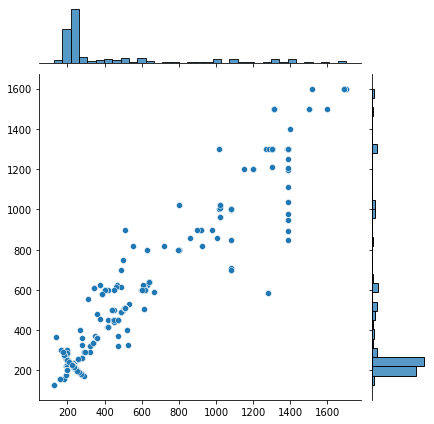

In [20]:
sns.jointplot(widths, heights)

In [30]:
np.mean(widths)

401.86284046692606

In [31]:
np.mean(heights)

398.74610894941634

In [40]:
image_shapes = (228, 225, 3)
batch_size = 16
dim = 7
depth = 256
input_dim = 100

In [38]:
image_gen = ImageDataGenerator(rescale=(1./255) * 2 - 1)

In [39]:
image_generator = image_gen.flow_from_directory(
    directory=image_path,
    target_size=image_shapes[:2],
    color_mode='rgb',
    batch_size=batch_size,
    save_format='jpg',
    class_mode=None
)

Found 1028 images belonging to 1 classes.


In [42]:
generator = Sequential()

generator.add(Dense(dim * dim * depth, input_shape=[input_dim]))
generator.add(Reshape((dim, dim, depth)))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
generator.add(Dropout(0.2))



In [44]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 7, 7, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)         0         
Total params: 633,984
Trainable params: 633,728
Non-trainable params: 256
_________________________________________________________________
